In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
model_name = "Qwen/Qwen3-4B"

# ✅ Load in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# ✅ Add LoRA adapters
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # Qwen uses q_proj/v_proj names
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
lora_model = get_peft_model(model, lora_config)

print("Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Loading checkpoint shards:  33%|███▎      | 1/3 [00:16<00:33, 16.57s/it]


KeyboardInterrupt: 

In [ ]:
ds = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT",'en')
ds

DatasetDict({
    train: Dataset({
        features: ['Question', 'Complex_CoT', 'Response'],
        num_rows: 19704
    })
})

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

def tok(data):
    text = [p + "\n" + r for (p, r) in zip(data["Question"], data["Response"])]
    model_inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=1024
    )
    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs

train_dataset = ds["train"].map(tok, batched=True, remove_columns=["Question", "Response"])

In [ ]:
training_args = TrainingArguments(
    output_dir="./qwen-lora-output",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,  # simulate batch size 8
    learning_rate=2e-4,
    fp16=True,
    num_train_epochs=2,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    push_to_hub=False
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)

In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.train()

C:\Users\aakas\AppData\Local\Temp\ipykernel_28168\1124989843.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,1.237500,1.212392
2,1.187000,1.177142


TrainOutput(global_step=4926, training_loss=1.2342733626340494, metrics={'train_runtime': 81330.5847, 'train_samples_per_second': 0.485, 'train_steps_per_second': 0.061, 'total_flos': 8.811840074699244e+17, 'train_loss': 1.2342733626340494, 'epoch': 2.0})

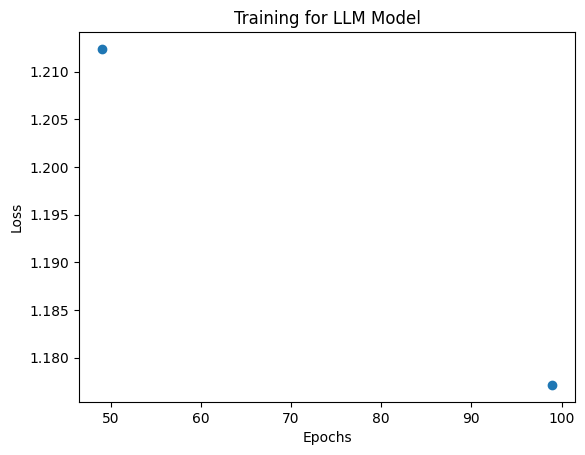

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
metrics_df = pd.DataFrame(trainer.state.log_history)

metrics_df['eval_loss'].plot(marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training for LLM Model")
plt.show()

In [ ]:
trainer.save_model("chatbot_model.pth")

In [ ]:
import torch
model = AutoModelForCausalLM.from_pretrained("chatbot_model.pth")
tokenizer = AutoTokenizer.from_pretrained("chatbot_model.pth")
model.eval()

Loading checkpoint shards: 100%|██████████| 3/3 [01:04<00:00, 21.52s/it]


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2560, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=2560, out_features=1024

In [15]:
prompt = '''A 42-year-old woman presents complaining of pain in her hands. She reports that the pain is in both hands, and that it is usually worse in the morning. She reports that her hands are also stiff in the morning, but that this gradually improves throughout the morning. She notes, however, that her symptoms seem to be getting worse over the last three months. What is the most likely pathogenesis of her disease process?
A. Repetitive microtrauma
B. Production of antibodies against smooth muscle
C. Production of antibodies against antibodies
D. Anti-neutrophil cytoplasmic antibody production'''
inputs = tokenizer(prompt,return_tensors="pt")

with torch.no_grad():
    outputs = model.generate(
        inputs['input_ids'],
        max_new_tokens=50,
        do_sample=True,
        temperature=0.9,
        top_p=0.95,
        repetition_penalty=1.2,
        pad_token_id = tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0],skip_special_tokens=False)
print(generated_text)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


A 42-year-old woman presents complaining of pain in her hands. She reports that the pain is in both hands, and that it is usually worse in the morning. She reports that her hands are also stiff in the morning, but that this gradually improves throughout the morning. She notes, however, that her symptoms seem to be getting worse over the last three months. What is the most likely pathogenesis of her disease process?
A. Repetitive microtrauma
B. Production of antibodies against smooth muscle
C. Production of antibodies against antibodies
D. Anti-neutrophil cytoplasmic antibody production
E. Autoantibodies against DNA-containing structures
The most likely underlying cause for the progressive worsening of hand joint stiffness and morning swelling in your patient would align with Sjögren’s syndrome rather than a classical rheumatic condition like lupus
